# Solution of TOV equations for a compat star


This Python notebook shows the numerical solution Tolman-Oppenheimer-Volkoff (TOV) that describe equilibrium configurations of nonrotating stars in General Relativity. It also computes the maximum mass for a sequence of stars.

Units: $c=G=M_{\odot}=1$

SB, General Relativity class, FSU Jena WS2018/19

https://bernuzzi.gitlab.io/gr/

# Import some Python library, set constants etc

In [0]:
import numpy as np # for arrays and math
import matplotlib.pyplot as plt # for plotting

# Conversion factors
LCGS = 1.476701332464468e+05 

## Equation of state (EOS)

Polytropic model: a simple model for the EOS. Pressure and total energy density are prescribed from the rest-mass density $\rho$ as

$$ P(\rho) = K \rho^\Gamma\\ e = \rho + P/(\Gamma-1) $$

where $(K,\Gamma)$ are two parameters. 

*Question*: What are the physical dimensions of $K$ ? 

In [0]:
def EOS_p2erc(p, K=100., Gamma=2.):
  """
  Equation of state (EOS)
  Given pressure, return energy density, rest-mass density and sound speed
  """      
  ene = (p/K)**(1./Gamma) + p/(Gamma-1.)
  rho = (p/K)**(1./Gamma)                       
  cs2 = K*Gamma*(Gamma-1)/(Gamma-1 + K*Gamma*rho**(Gamma-1))*rho**(Gamma-1)
  return ene, rho, cs2

def EOS_r2pe(rho, K=100., Gamma=2.):
  """
  Equation of state (EOS)
  Given rest-mass density, return energy density and pressure
  Polytropic EOS: P = k rho^Gamma
  """
  p = K*rho**Gamma
  e = rho + p/(Gamma-1.);
  return p, e

## Tolmann-Oppenheimer-Volkhoff equations

In [0]:
def TOV(t, y):
  """
  Tolmann-Oppenheimer-Volkhoff equations
  d/dt y(t) = R.H.S. 
  """
  r = t
  # Unpack state array
  m = y[0] # mass of a sphere of radius r
  p = y[1] # pressure
  # Call the EOS
  ene, dummy1, dummy2 = EOS_p2erc(p) 
  # Set the RHS
  dy = np.empty_like(y)
  dy[0] = 4*np.pi*ene*r**2                               
  dy[1] = -(ene+p)*(m + 4*np.pi*r**3*p)/(r*(r-2*m))
  return dy
  
def found_radius(t,y ,pfloor=0.):
  """
  Event function: Zero of pressure 
  ODE integration stops when this function returns True
  """
  return ((y[1]-pfloor)<=0.)

## The Euler algorithm to solve ODE


The routine below implements a very robust and simple algoirthm for ODE integration.

*Exercise*: Implement a more sophisticated algoriithm like Runge-Kutta or use [SciPy](https://docs.scipy.org/doc/scipy/reference/integrate.html) routine. Verify your results.

In [0]:
def solve_ode_euler(t, y0, dydt_fun, stop_event=None, verbose=False):
  """
  Euler algorithm 
  NOTE: solution is not stored/saved, just return last point
  """
  N = len(t)
  dt = np.diff(t)[0] # assume a uniformly space t array
  y = y0
  for i in range(N):
    yprev = np.copy(y) # store previous for returning pre-event data
    y += dt * dydt_fun(t[i],y)
    if verbose: print(t[i],y)
    if stop_event: 
      if bool(stop_event(t[i],y)): 
        print("Event reached.")
        return t[i-1], yprev 
  if stop_event: print("No event reached")
  return t[i], y

## Choose integration parameters


Equations are singular at $r=0$, we need to start at a small radius `rmin`. 

The outer radius of the integration grid `rmax` must be choosen sufficiently large such that $r_\text{max}>R$, where $R$ is  the unknown star radius.

In [0]:
rmin, rmax = 1e-6, 20. 
N = 100 # number of points between rmin and rmax
rspan = np.linspace(rmin,rmax,N)

## Initial conditions for a star with $M\sim1.4M_{\odot}$

ODE integration will start at $r\sim0$. The "initial" central pressure is set for a given central rest-mass density value. The initial mass at $r=0$ is $m(0)=0$ but since we start from a positive small radius value we integrate the equation from $r=0$ to $r=$`rmin` (small).

*Exercise:* Convert $\rho$ to CGS units and derive the conversion factor for lengths to km (`LCGS`)

*Exercise:* Derive the equation used in the initial condition for $m(r)$.



In [0]:
rho0 = 1.28e-3 # Central (maximal) rest-mass density
p0,e0 = EOS_r2pe(rho0)
m0    = 4./3.*np.pi*e0*rmin**3
sol0 = [m0, p0]

## Solve the IVP for a star with $M\sim1.4M_{\odot}$




In [259]:
t, sol = solve_ode_euler(rspan, sol0, TOV, stop_event=found_radius, verbose=True)

1e-06 [3.66542577e-15 1.63839997e-04]
0.2020211919191919 [0.0001496 0.0001637]
0.4040413838383838 [0.0007477  0.00016314]
0.6060615757575757 [0.00209083 0.00016207]
0.8080817676767676 [0.00446993 0.0001605 ]
1.0101019595959595 [0.00816716 0.00015842]
1.2121221515151512 [0.01345275 0.00015585]
1.4141423434343432 [0.02058188 0.0001528 ]
1.6161625353535352 [0.02979174 0.00014929]
1.8181827272727271 [0.04129865 0.00014534]
2.0202029191919193 [0.05529546 0.00014099]
2.222223111111111 [0.07194903 0.00013626]
2.4242433030303028 [0.09139805 0.0001312 ]
2.626263494949495 [0.11375106 0.00012582]
2.8282836868686867 [1.39084737e-01 1.20181310e-04]
3.030303878787879 [1.67442540e-01 1.14317323e-04]
3.2323240707070706 [1.98833631e-01 1.08271592e-04]
3.4343442626262624 [2.33232149e-01 1.02087756e-04]
3.6363644545454545 [2.70576832e-01 9.58100324e-05]
3.8383846464646463 [3.10770998e-01 8.94827450e-05]
4.0404048383838385 [3.53682889e-01 8.31498446e-05]
4.24242503030303 [3.99146373e-01 7.68544244e-05]
4.

In [260]:
# Get mass and radius
R = t * LCGS * 1e-5 # km 
M = sol[0] # Msun
pmin = sol[1]
print(pmin,R,M)

2.2867788285059276e-07 12.82791140014866 1.4045085183791897


## Construct an equilibrium sequence of stars and calculate the maximum mass

*Exercise*  The observed masses of the known neutron stars are summarized in [this paper](https://arxiv.org/abs/1305.3510) 
(see also e.g. https://stellarcollapse.org/nsmasses) Compare the results obtained here with the politropic EOS and those observed. What do you conclude about the EOS model we used?

In [0]:
def set_initial_conditions(rho, rmin):
  """
  Utility routine to set initial data, given rho0
  """
  p,e = EOS_r2pe(rho)
  m    = 4./3.*np.pi*e*rmin**3
  return m, p

In [262]:
# Let us increase the resolution to have better data
N = 1000 # number of points between rmin and rmax
rspan = np.linspace(rmin,rmax,N)

# Build 200 star models
rhospan = np.linspace(0.6e-4,7e-3,200)
R = []
M = []

for rho0 in rhospan:
  # Solve TOV for rho0
  sol0 = set_initial_conditions(rho0, rmin)
  t, sol = solve_ode_euler(rspan, sol0, TOV, stop_event=found_radius)
  R.append(t)
  M.append(sol[0])
  
  
M = np.array(M)
R = np.array(R)

Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reac

In [263]:
# Find index of maximum mass star
immax = np.argmax(M)
Mmax = M[immax]
Rmax = R[immax]
print(idx,Mmax,Rmax)

87 1.634011539648842 7.587588208208208


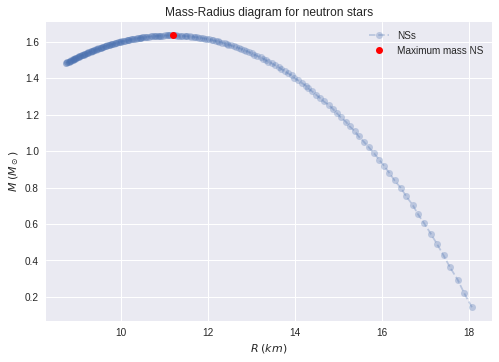

In [264]:
km = LCGS * 1e-5
fig = plt.figure()
ax = plt.subplot(111)
plt.title('Mass-Radius diagram for neutron stars')
plt.plot(R*km,M, 'o--', label='NSs', alpha=0.3)
plt.plot(Rmax*km,Mmax, 'ro', label='Maximum mass NS')
ax.legend()
plt.xlabel('$R$ $(km)$')
plt.ylabel('$M$ $(M_\odot)$')
fig.savefig('TOV.png')
plt.show()
